# Executando o MegaDetector em imagens de armadilhas fotográficas usando o Google Colab

# Configure a instância do Colab para ser executada em um acelerador de GPU

Navegue até Editar → Configurações do Notebook e selecione "GPU" no menu suspenso "Acelerador de hardware".

# Instalando dependências e baixando o modelo

A partir daqui, você começará a ver uma mistura de código e comandos do sistema Linux. Os comandos do sistema são prefixados por um shebang !, que informa a este notebook para executá-los na linha de comando.

## Instale os pacotes Python necessários

*   **humanfriendly**: pacote que fornece utilitários para tornar a interação com usuários mais amigável.
*   **jsonpickle**: pacote que estende a biblioteca padrão de serialização JSON do Python para suportar objetos mais complexos, como instâncias de classes personalizadas. Ele permite que você serialize e desserialize objetos Python de forma mais flexível do que a biblioteca JSON padrão.
*   **ultralytics**: pacote que fornece ferramentas para treinamento de modelos de aprendizado profundo e análise de experimentos. Ele é particularmente útil para tarefas relacionadas a visão computacional e detecção de objetos. Ultralytics é frequentemente usado em conjunto com o framework PyTorch.
*   **PyTorch**: framework de aprendizado profundo. Ele fornece estruturas flexíveis para a construção e treinamento de modelos de aprendizado de máquina, especialmente em tarefas relacionadas a redes neurais.
*    **pip**: gerenciador de pacotes do Python, para instalar esses pacotes no ambiente em que você está trabalhando.

In [ ]:
# !pip install yolov5
# !pip install megadetector
# !pip install utils
!pip install humanfriendly jsonpickle ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 15.7 MB/s eta 0:00:00


## Clone os repositórios git necessários

Isso copiará a versão mais recente dos repositórios MegaDetector e YOLOv5, que são necessários para executar o MegaDetector. Bem como o download do MegaDetector v5a.

In [ ]:
# rm: Comando usado para remover arquivos ou diretórios.
# -rf: Opções do comando rm. "r" indica remoção recursiva (para diretórios e seu conteúdo) e
#      "f" significa forçar, ignorando mensagens de confirmação.
!rm -rf /content/MegaDetector
!rm -rf /content/yolov5
!rm -rf /content/modelo.pt
!rm -rf /content/sample_data

# Clone os repositórios git necessários
# wget: usada para baixar arquivos da web diretamente para o sistema de arquivos local.
# -o: atributo do wget para redirecionar a saída para um arquivo.
!wget -O modelo.pt https://github.com/agentmorris/MegaDetector/releases/download/v5.0/md_v5a.0.0.pt

!git clone https://github.com/agentmorris/MegaDetector.git

!git clone https://github.com/ultralytics/yolov5
%cd yolov5
# q (quiet): usado para executar a instalação em modo silencioso (sem mensagens de saída),
#            e "r" (requirements) indica que os pacotes devem ser instalados a partir de um arquivo
# comet_ml: pacote específico que está sendo instalado
%pip install -qr requirements.txt comet_ml


# Carregando a base de imagens

In [ ]:
!rm -rf /content/img_entrada
!rm -rf /content/img_saida

%cd /content/
# Pacote para baixar arquivo do Google Drive
import gdown

url = "https://drive.google.com/drive/folders/1Jit2Hzs-OCa9HKgUyqRG1rF-5Mrc4swf?usp=sharing"
# url: A URL do diretório que você deseja baixar.
# quiet=True: silencioso, a função será executada sem imprimir mensagens na saída padrão.
# use_cookies=False: False, a função não usará cookies durante o download.
gdown.download_folder(url, quiet=True, use_cookies=False)

# import os
# os.makedirs('/content/img_saida', exist_ok=True)

/content


['/content/img_entrada/download.jpg',
 '/content/img_entrada/ee402f0f1423053b39dda1fb8a0f12d8.jpg',
 '/content/img_entrada/jaguatirica-leonardo-mercon-2-conexao-planeta-800x445-1.jpg',
 '/content/img_entrada/paca.jpg',
 '/content/img_entrada/S1_D05_R4_PICT0075.JPG']

## Definido PYTHONPATH para incluir MegaDetector e yolov5

Adicione pastas git clonadas à `PYTHONPATH` variável de ambiente para que possamos importar seus módulos de qualquer diretório de trabalho.

*   **os**: módulo que fornece uma maneira de interagir com o sistema operacional, incluindo a manipulação de variáveis de ambiente.
*   **PYTHONPATH**: para adicionar um diretório específico ao caminho de pesquisa do Python, permitindo que o interpretador Python encontre módulos e pacotes nesse diretório. Essa alteração no PYTHONPATH pode ser útil quando você está trabalhando com projetos que possuem módulos ou pacotes em diretórios personalizados, garantindo que o Python consiga encontrá-los durante a execução do código.



In [ ]:
import os

os.environ['PYTHONPATH'] += ":/content/MegaDetector"
os.environ['PYTHONPATH'] += ":/content/yolov5"
os.environ['PYTHONPATH'] += ":/content/img_entrada"
os.environ['PYTHONPATH'] += ":/content/img_saida"

# Processamento em lote do MegaDetector

## Execução da detecção

*   **!python**: chamando o interpretador Python para executar um script.
*   **"\$detector"**: argumento com o caminho do módulo para o script ou módulo Python que será executado.
*   **modelo.pt**: argumento que está sendo passado para o script Python, com o nome de um arquivo de modelo que o script utilizará.
*   **"img_entrada"**: argumento com o caminho das imagens de entrada.
*   **"\$arq_saida"**: argumento que representa o caminho da pasta que guardará a saída.
*   **--recursive**: opção específica para o script Python, indicando que o script deve operar de forma recursiva em subdiretórios.
*   **--output_relative_filenames**: opção específica para o script Python, indicando que os nomes dos arquivos de saída devem ser dados de forma relativa.
*   **--quiet**: opção específica para o script Python,  indicando que a execução do script deve ser silenciosa, sem mensagens desnecessárias na saída.

In [ ]:
# Local do módulo que ira fazer a detecção
detector = '/content/MegaDetector/detection/run_detector_batch.py'
# Escolha um local para o arquivo JSON de saída
arq_saida = '/content/megadetector-results.json'

!python "$detector" modelo.pt "img_entrada" "$arq_saida" --recursive --output_relative_filenames --quiet

5 image files found in the input directory
PyTorch reports 0 available CUDA devices
GPU available: False
Imported YOLOv5 as utils.*
Using PyTorch version 2.1.0+cu118
Fusing layers... 
Model summary: 574 layers, 139990096 parameters, 0 gradients, 207.9 GFLOPs
Loaded model in 11.98 seconds
Loaded model in 11.98 seconds
100% 5/5 [00:59<00:00, 11.90s/it]
Finished inference for 5 images in 1 minute and 17.05 seconds (0.06 images per second)
Output file saved at /content/megadetector-results.json
Done!


## Visualize saídas de script de processamento em lote

Aqui usamos o `visualize_detector_output.py` da pasta `md_visualization` do repositório **MegaDetector** para marcar os objetos detectados.

*   **"\$modulo_viz"**: argumento passado para o script Python com o caminho para módulo Python que será executado.
*   **"\$arq_saida"**: argumento da variável com o caminho do arquivo de dados de saída.
*   **"img_saida"**: argumento com o caminho das pasta das imagem de saída.
*   **--confidence 0.2**: opção específica para o script Python, indicando que um limiar de confiança de 0.2 está sendo definido para a visualização.
*   **--images_dir "img_entrada"**: opção específica que indica que o diretório contendo as imagens de entrada está sendo especificado.

In [ ]:
# Local do módulo que fará a marcação dos animais detectados
modulo_viz = '/content/MegaDetector/md_visualization/visualize_detector_output.py'

# Renderize caixas delimitadoras em nossas imagens
!python "$modulo_viz" "$arq_saida" "img_saida" --confidence 0.2 --images_dir "img_entrada"

Using custom label mapping
Detector output file contains 5 entries.
Rendering detections above a confidence threshold of 0.2
100% 5/5 [00:00<00:00, 23.85it/s]
Skipped 0 failed images (of 5)
Skipped 0 missing images (of 5)
Rendered detection results on 5 images, saved to img_saida


/content
anno_ee402f0f1423053b39dda1fb8a0f12d8.jpg


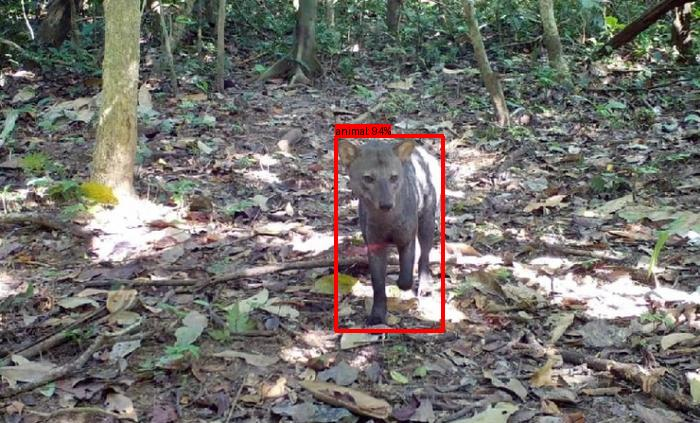

anno_jaguatirica-leonardo-mercon-2-conexao-planeta-800x445-1.jpg


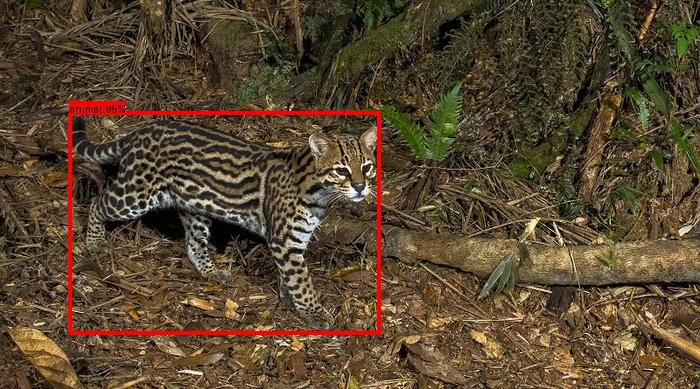

anno_download.jpg


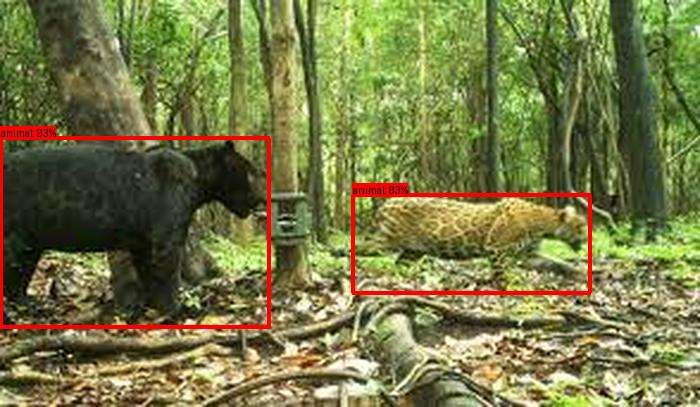

anno_S1_D05_R4_PICT0075.JPG


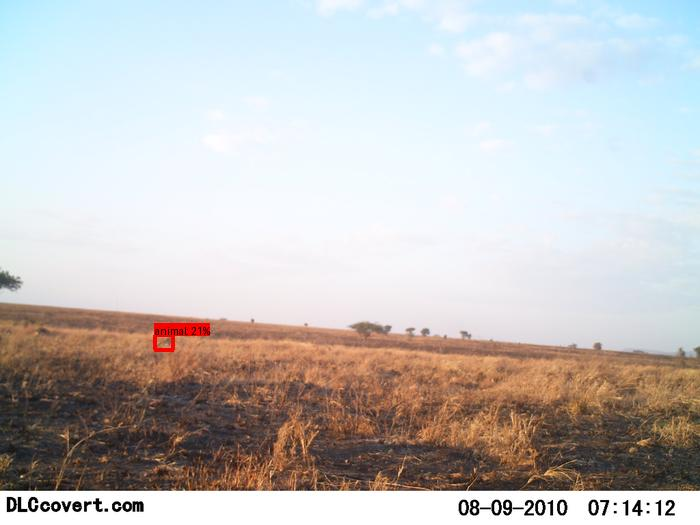

anno_paca.jpg


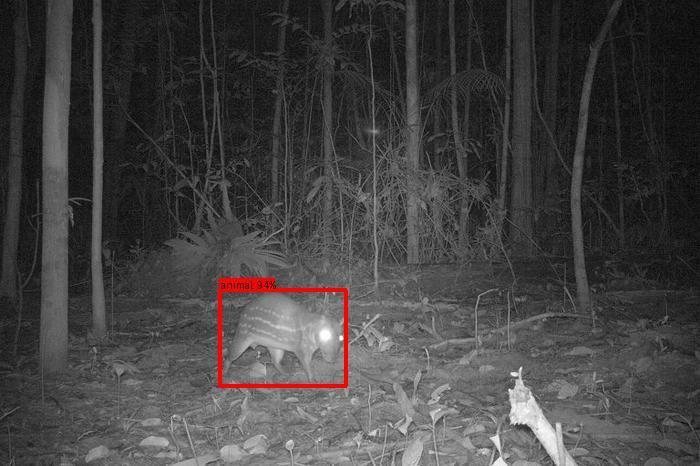

In [ ]:
%cd /content/
# Mostre as imagens com caixas delimitadoras no Colab
from IPython.display import Image, display

for nome_img_saida in os.listdir("img_saida"):
  print(nome_img_saida)
  # Use a função Image para criar um objeto de imagem
  imagem = Image(filename=os.path.join("img_saida", nome_img_saida), width=400)
  # Exiba a imagem
  display(imagem)
